# Titanic: Exploring Survival

As per wikipedia, Titanic was a British passenger liner operated by the White Star Line that sank in the North Atlantic Ocean on 15 April 1912, after striking an iceberg during her maiden voyage from Southampton to New York City. Of the estimated 2,224 passengers and crew aboard, more than 1,500 died, making the sinking at the time one of the deadliest of a single ship[a] and the deadliest peacetime sinking of a superliner or cruise ship to date.

https://en.wikipedia.org/wiki/Titanic

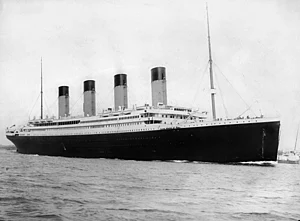

**Our main goal is who can survive and who can not?!**

Please like or comment if you like my work :)

# Import libriaries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from collections import Counter


In [ ]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

# Initial inspection of dataset

In [ ]:
train.head()

In [ ]:
train.info()

print('*'*30)

test.info()

# Missing Values Corrections
We will try to fill missing values by mean/median/mode. But note that it's also not 100% accurate. You can also use models like Decision Trees and Random Forest to handle missing values

In [ ]:
# Lets find columns with null values
train.isnull().sum()

In [ ]:
# Check missing value from dataset
plt.figure(figsize=(18,18))
plt.subplot(221)
sns.heatmap(data=train.isnull())
plt.subplot(222)
sns.heatmap(data=test.isnull())

Cabin has 687 missing values which is 80% of data so we should drop cabin.

In [ ]:
# Lets drop Cabin column because it have alot of missing value that will effect accuracy of model

train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

In [ ]:
# Replace missing Age with mean value of Age column. Its best way to correct the dataset when percentage of missing value of are less

train['Age'].fillna(train.Age.mean(), inplace=True)
test['Age'].fillna(test.Age.mean(), inplace=True)

train['Fare'].fillna(train.Fare.mean(), inplace=True)
test['Fare'].fillna(test.Fare.mean(), inplace=True)

In [ ]:
# lets see if there are any more columns with missing values 

plt.figure(figsize=(18,18))
plt.subplot(221)
sns.heatmap(data=train.isnull())
plt.subplot(222)
sns.heatmap(data=test.isnull())

Now both datasets looks clean without missing values. We can proceed further cleaning and modeling process

In [ ]:
# Now lets check howmany man/female can survived/not-survived using count plot

plt.figure(figsize=(10,4))
sns.set_style('whitegrid')
sns.set(font_scale=1)

sns.countplot(x='Survived', data=train,hue="Sex")
plt.xlabel('0=Not-Survived, 1=Survived')
plt.ylabel('Number of Male and Female')
plt.title('Gender wise Education visualization')
plt.show()

Number of death of man is very high comparing to females. More than 400 male passenger could not survived where as around 90 female could not survived

# Outlier detection with Interquartile Range(IQR)

Identifying outliers in data is an important part of statistical analysis. IQR is measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 −  Q1. 

When a data set has outliers or extreme values, we summarize a typical value using the median as opposed to the mean.  When a data set has outliers, variability is often summarized by a statistic called the interquartile range, which is the difference between the first and third quartiles. The first quartile, denoted Q1, is the value in the data set that holds 25% of the values below it. The third quartile, denoted Q3, is the value in the data set that holds 25% of the values above it. The quartiles can be determined following the same approach that we used to determine the median, but we now consider each half of the data set separately. The interquartile range is defined as follows:


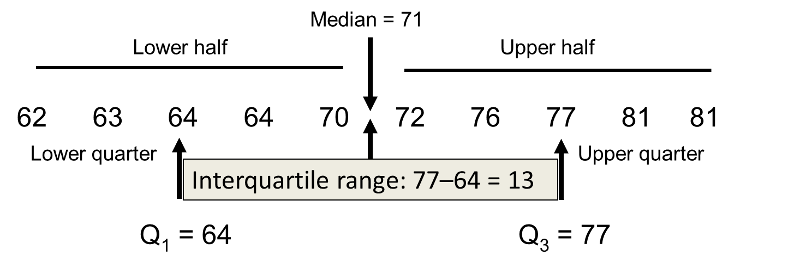

In [ ]:
outliers_features = ["Age","SibSp","Parch","Fare"]
outlier_indices = []
for col in outliers_features:
    # 1st quartile (25%)
    Q1 = np.percentile(train[col], 25)
    
    # 3rd quartile (75%)
    Q3 = np.percentile(train[col],75)
    
    # Interquartile range (IQR)
    IQR = Q3 - Q1

    # outlier step
    outlier_step = IQR * 1.5

    # Determine a list of indices of outliers for feature col
    columns_idx = train[(train[col] < Q1 - outlier_step) | (train[col] > Q3 + outlier_step )].index

    # append the found outlier indices for col to the list of outlier indices 
    outlier_indices.extend(columns_idx)

# select observations containing more than 2 outliers
outlier_indices = Counter(outlier_indices)        
outliers_to_drop = list( k for k, v in outlier_indices.items() if v > 2 )

I used Tukey method to find outliers. Tukey's rule says that the outliers are values more than 1.5 times the interquartile range from the quartiles — either below Q1 − 1.5IQR, or above Q3 + 1.5 IQR

In [ ]:
train.loc[outliers_to_drop] # Show the outliers rows

we found some alot of SibSp has high value. lets drop all of the outliers

In [ ]:
# Drop outliers
train = train.drop(outliers_to_drop, axis = 0).reset_index(drop=True)

In [ ]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# Visualizations

In [ ]:
# The Age is measured on very different scaling. So we need to do feature scaling before we start predictions

plot = sns.FacetGrid(train, col="Sex", margin_titles=True, row="Survived")
plot.map(plt.hist, "Age",color="blue");

We can see maximum people between 25-30 year could not survived. That's also because of titanic has more young people

In [ ]:
#Let's see Age distribution by classes
plt.figure(figsize=(15,7))
plt.xlabel("Age")    
plt.title("Class wise Age Distribution")
plt.legend(('1st Class', '2nd Class','3rd Class'),loc='best') ;

train.Age[train['Pclass'] == 1].plot(kind="kde")
train.Age[train['Pclass'] == 2].plot(kind="kde")
train.Age[train['Pclass'] == 3].plot(kind="kde")


In [ ]:
train

In [ ]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

# Feature Engineering (Convert Categorical variables into Numerical ones)

In [ ]:
# We can define no of family members as new feature

train['Family_members'] = train['SibSp'] + train['Parch'] 
test['Family_members'] = test['SibSp'] + test['Parch'] 

In [ ]:
# We can also add title as new feature that will help to increase accuracy

train['Title'] = train['Name'].map(lambda name: (name.split(',')[1].split('.')[0].strip()))
test['Title'] = test['Name'].map(lambda name: (name.split(',')[1].split('.')[0].strip()))

In [ ]:
plt.figure(figsize=(17,7))
sns.countplot(x='Title', data=train)

In [ ]:
# Dropping PassengerId and Ticket column

#train.drop(['PassengerId','Ticket', 'Name'], axis = 1, inplace = True)
#test.drop(['Ticket', 'Name'], axis = 1, inplace = True)

In [ ]:
# Label encoding the categorical columns of dataset

LabelEnco = LabelEncoder()

columnNames = ['Embarked','Sex', 'Title']
for col in columnNames:
    train[col] = LabelEnco.fit_transform(train[col])
    test[col] = LabelEnco.fit_transform(test[col])

train.head()

In [ ]:
# Exploring Pclass and i created three new columns according to the Pclass column

train['Pclass_3'] = train['Pclass'].map(lambda x: (x == 3))
train['Pclass_2'] = train['Pclass'].map(lambda x: (x == 2))
train['Pclass_1'] = train['Pclass'].map(lambda x: (x == 1))

test['Pclass_3'] = test['Pclass'].map(lambda x: (x == 3))
test['Pclass_2'] = test['Pclass'].map(lambda x: (x == 2))
test['Pclass_1'] = test['Pclass'].map(lambda x: (x == 1))

In [ ]:
# Storing categorial values into separate columns with 1/0 values

train.Sex.value_counts()
train['is_male'] = train['Sex'].map(lambda x: (x == 1))
train['isfemale'] = train['Sex'].map(lambda x: (x == 0))

test['is_male'] = test['Sex'].map(lambda x: (x == 1))
test['isfemale'] = test['Sex'].map(lambda x: (x == 0))

In [ ]:
# Prepare train and test data for modeling

X_train = train.drop(['PassengerId','Ticket', 'Name', 'Survived', 'Pclass', 'Sex'], axis=1)
Y_train = train['Survived']
X_test = test.drop(['Ticket', 'Name', 'PassengerId', 'Pclass', 'Sex'], axis=1)

print("shape of X_train",X_train.shape)
print("Shape of Y_train",Y_train.shape)
print("Shape of x_test",X_test.shape)

In [ ]:
train.head()

In [ ]:
# We shall now plot the numberical variables to look at the distribution
numerical = ['Pclass','Sex','Age']
sns.pairplot(data=train, x_vars=numerical, hue='Survived', palette='Set1')

# LogisticRegression
In statistics, the logistic model (or logit model) is used to model the probability of a certain class or event existing such as pass/fail, win/lose, alive/dead or healthy/sick. This can be extended to model several classes of events such as determining whether an image contains a cat, dog, lion, etc. Each object being detected in the image would be assigned a probability between 0 and 1, with a sum of one.

In [ ]:
# Import Libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, mean_absolute_error, mean_squared_error,precision_recall_curve

In [ ]:
# Create function to generate headmap of confusion matrix, we are defining the function so that we can resuse it in various model evalution

def show_matrix(x, y):
    matrix = confusion_matrix(x, y)
    sns.heatmap(matrix, annot = True,fmt = 'g')
    plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

logisticModel = LogisticRegression(max_iter=200, solver='newton-cg')
logisticModel.fit(X_train, Y_train)

In [ ]:
logiPred = logisticModel.predict(X_train)

# Plotting the confusion matrix in heatmap
show_matrix(Y_train, logiPred)

In [ ]:
# Check prediction score of Logistic model
precision_score(Y_train, logiPred)*100

In [ ]:
logiAcScore = accuracy_score(Y_train, logiPred)*100
logiMse = mean_squared_error(Y_train, logiPred)*100

# We will use this variables further in model comparison

In [ ]:
# Precision-Recall vs Threshold Chart, explore the training result

logipp = logisticModel.predict_proba(X_train)

precision, recall, thresholds = precision_recall_curve(Y_train, logipp[:,1])

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


# KNeighbors Classifier
In statistics, the k-nearest neighbors algorithm (k-NN) is a non-parametric classification method first developed by Evelyn Fix and Joseph Hodges in 1951,[1] and later expanded by Thomas Cover.[2] It is used for classification and regression. In both cases, the input consists of the k closest training examples in data set.

In [ ]:
# Import model
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knnModel = KNeighborsClassifier(n_neighbors=3, algorithm='auto', leaf_size=35)
knnModel.fit(X_train, Y_train)

In [ ]:
# Prdict of KNN model
knnPrediction = knnModel.predict(X_train)

In [ ]:
# Plotting the confusion matrix in heatmap
show_matrix(Y_train, knnPrediction)

Here out of 891 total predictions, KNN did 139 wrong predictions

In [ ]:
np.round(precision_score(Y_train, knnPrediction)*100, 3)

In [ ]:
knnpp = knnModel.predict_proba(X_train)

precision, recall, thresholds = precision_recall_curve(Y_train, knnpp[:,1])

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


In [ ]:
knnAcScore = accuracy_score(Y_train, knnPrediction)*100
knnMse = mean_squared_error(Y_train, knnPrediction)*100

# DecisionTree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtcModel = DecisionTreeClassifier(max_depth=8)
dtcModel.fit(X_train, Y_train)
DTCPreds = dtcModel.predict(X_train)

In [ ]:
# Plotting the confusion matrix in heatmap
show_matrix(Y_train, DTCPreds)

dtcAcScore = accuracy_score(Y_train, DTCPreds)*100
dtcMse = mean_squared_error(Y_train, DTCPreds)*100

In [ ]:
np.round(precision_score(Y_train, DTCPreds)*100, 3)

In [ ]:
DTCpp = dtcModel.predict_proba(X_train)

precision, recall, thresholds = precision_recall_curve(Y_train, DTCpp[:,1])

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


# RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
RMModel = RandomForestClassifier(max_features='sqrt', random_state=5, max_depth=100)
# max_features='sqrt', random_state=5
RMModel.fit(X_train, Y_train)

RMPreds = RMModel.predict(X_train)

# Plotting the confusion matrix in heatmap
show_matrix(Y_train, RMPreds)

In [ ]:
rmpp = RMModel.predict_proba(X_train)

precision, recall, thresholds = precision_recall_curve(Y_train, rmpp[:,1])

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])


In [ ]:
rmAcScore = accuracy_score(Y_train, RMPreds)*100
rmMse = mean_squared_error(Y_train, RMPreds)*100

np.round(precision_score(Y_train, RMPreds)*100, 3)

# Model Comparison

In [ ]:
print("------------------------------")
print("Logistic Regression")
print("------------------------------")
print("Accuracy score of KNN model is", np.round(logiAcScore, 3))
print("Mean squared error of KNN model is", np.round(logiMse, 3))
print("")
print("------------------------------")
print("KNN")
print("------------------------------")
print("Accuracy score of KNN model is", np.round(knnAcScore, 3))
print("Mean squared error of KNN model is", np.round(knnMse, 3))
print("")
print("------------------------------")
print("Decision Tree")
print("------------------------------")
print("Accuracy score of DecisionTree model is", np.round(dtcAcScore, 3))
print("Mean squared error of DecisionTree model is", np.round(dtcMse, 3))
print("")
print("------------------------------")
print("RandomForestClassifier")
print("------------------------------")
print("Accuracy score of RandomForestClassifier model is", np.round(rmAcScore, 3))
print("Mean squared error of RandomForestClassifier model is", np.round(rmMse, 3))

As you can see here of RandomForestClassifier model's **accuracy** and **MSE** is batter than other. We will try out other models and evaluate their results

**Continueing in newer version**

# Submission

In [ ]:
Y_test = RMModel.predict(X_test)
acc_log = round(RMModel.score(X_train, Y_train) * 100, 2)
acc_log

In [ ]:
X_test

In [ ]:
submission = pd.DataFrame({
    "PassengerId": test["PassengerId"],
    "Survived": Y_test
})
print(submission)

# submission.to_csv('./submission.csv', index=False)